# Object Detection Demo
Welcome to the object detection inference walkthrough!  This notebook will walk you step by step through the process of using a pre-trained model to detect objects in an image. Make sure to follow the [installation instructions](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/installation.md) before you start.

# Imports

In [1]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile
import cv2

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# バージョン確認
if tf.__version__ < '1.4.0':
    raise ImportError('Please upgrade your tensorflow installation to v1.4.* or later!')

## Env setup

In [2]:
# This is needed to display the images.
%matplotlib inline

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")

## Object detection imports
Here are the imports from the object detection module.

In [3]:
from utils import label_map_util

from utils import visualization_utils as vis_util

# Model preparation 

## Variables

「Model preparation」の「Variables」を今回学習させたファイル用に書き換える   
修正箇所は下記の３つ   
* PATH_TO_CKPT   （学習済みモデル）
* PATH_TO_LABELS   
* NUM_CLASSES   

Any model exported using the `export_inference_graph.py` tool can be loaded here simply by changing `PATH_TO_CKPT` to point to a new .pb file.  

By default we use an "SSD with Mobilenet" model here. See the [detection model zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md) for a list of other models that can be run out-of-the-box with varying speeds and accuracies.

## 自分の学習済みモデル

In [4]:
# tarファイルの解凍

# 学習させたモデルから作成したfrozen_inference_graphファイル
PATH_TO_CKPT = '/Users/1-10robotics/Desktop/remote/train/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = '/Users/1-10robotics/Desktop/remote/label_map.pbtxt'

# 分類クラス数
NUM_CLASSES = 38

## Load a (frozen) Tensorflow model into memory.

In [5]:
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

## Loading label map
Label maps map indices to category names, so that when our convolution network predicts `5`, we know that this corresponds to `airplane`.  Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine

In [6]:
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)
print(category_index)

{1: {'id': 1, 'name': 'pepper'}}


## Helper code

In [7]:
def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape((im_height, im_width, 3)).astype(np.uint8)

# Detection

In [8]:
"""PATH_TO_TEST_IMAGES_DIRにテスト画像を配置する"""
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = '/Users/1-10robotics/Desktop/pepper/objectdetection/test_images'
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'image{}.jpg'.format(i)) for i in range(1, 12) ]

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

image: /Users/1-10robotics/Desktop/pepper/objectdetection/test_images/image1.jpg
scores: [0.99932253 0.08085705 0.07203592 0.06656625 0.04859491 0.04605122
 0.04598964 0.03828435 0.03164731 0.0170793  0.01460373 0.01403636
 0.01329045 0.01135193 0.01128121 0.01127342 0.01004539 0.00993572
 0.0093424  0.00855346 0.00709736 0.00708059 0.00699023 0.00673625
 0.0066509  0.00663859 0.00657482 0.00649942 0.00640683 0.0063884
 0.00638323 0.00631733 0.00630953 0.00624552 0.00621576 0.00618996
 0.006084   0.00604466 0.00601672 0.00598661 0.00593923 0.00584336
 0.0058074  0.00572578 0.00571783 0.0056312  0.00562834 0.00560548
 0.00554264 0.00551656 0.00546834 0.00544264 0.00538171 0.00535994
 0.00529273 0.00522744 0.00516025 0.00511412 0.00508222 0.00505365
 0.0050327  0.00498597 0.00493081 0.00491764 0.00490987 0.00482751
 0.00482118 0.00479417 0.00465558 0.00461581 0.00458787 0.00454615
 0.00452594 0.00451647 0.00448387 0.00444225 0.00442915 0.00440397
 0.00435593 0.004353   0.0043472  0.00431

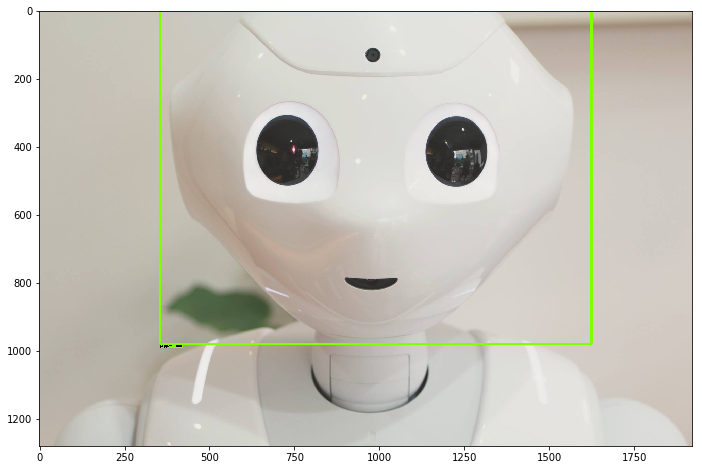

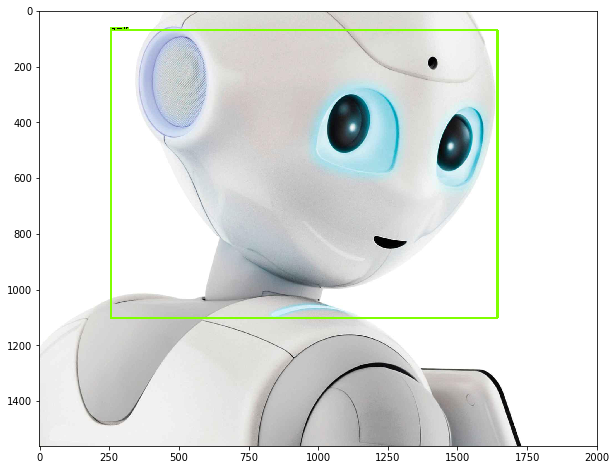

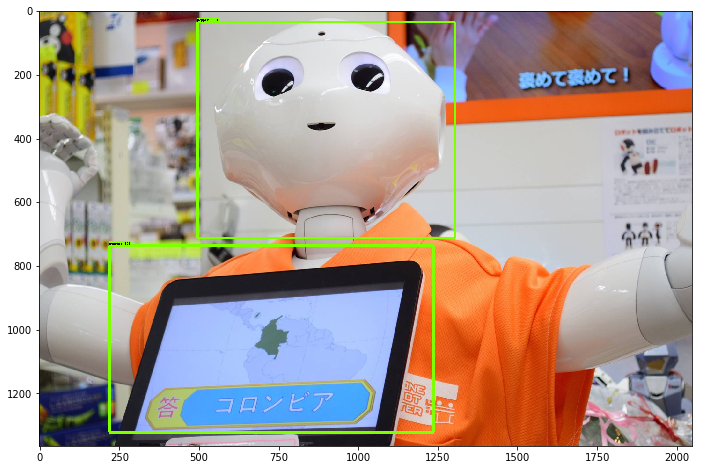

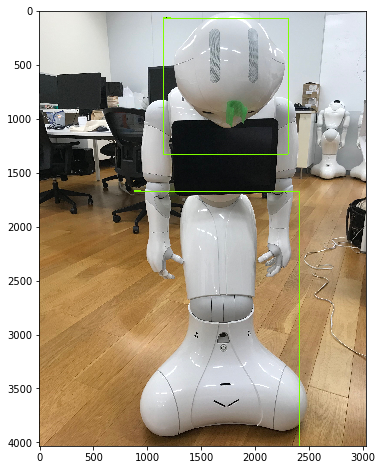

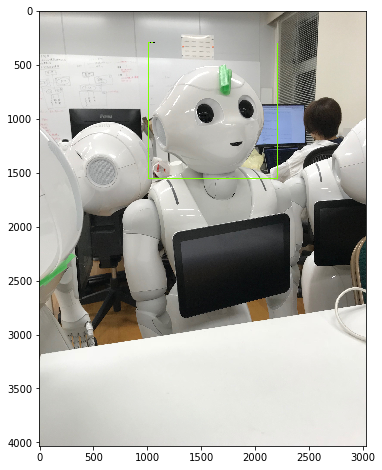

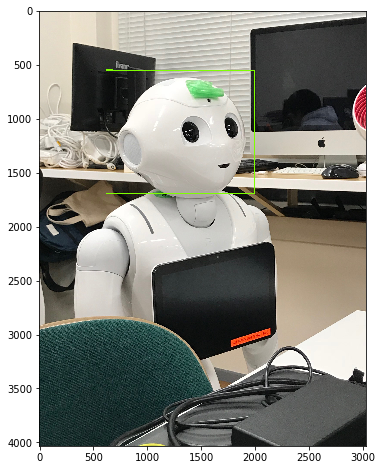

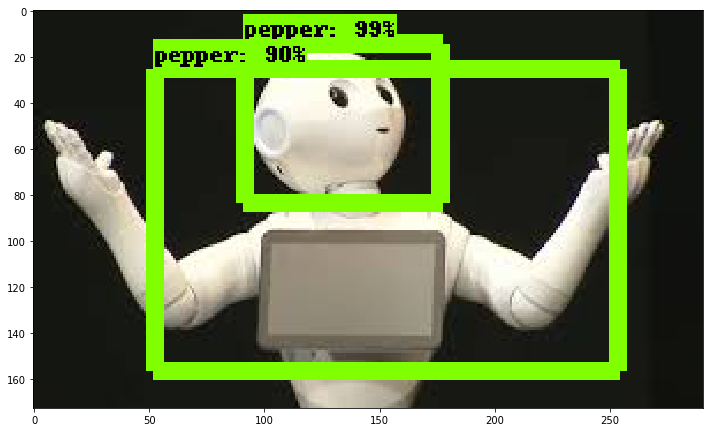

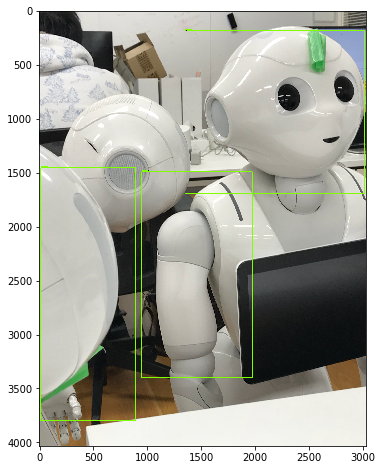

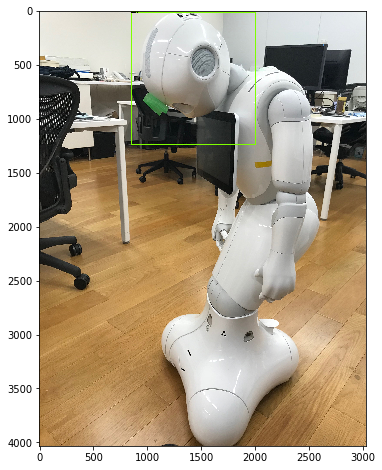

In [9]:
with detection_graph.as_default():
    with tf.Session(graph=detection_graph) as sess:
        # Definite input and output Tensors for detection_graph
        image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
        # Each box represents a part of the image where a particular object was detected.
        detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
        # Each score represent how level of confidence for each of the objects.
        # Score is shown on the result image, together with the class label.
        detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
        detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
        num_detections = detection_graph.get_tensor_by_name('num_detections:0')
    
        for image_path in TEST_IMAGE_PATHS:
            try:
                image = Image.open(image_path)
                print('image: {}'.format(image_path))
                # the array based representation of the image will be used later in order to prepare the
                # result image with boxes and labels on it.
                image_np = load_image_into_numpy_array(image)
                # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
                image_np_expanded = np.expand_dims(image_np, axis=0)

                """Actual detection.""" 
                # boxes: 物体の位置を表わす座標（枠囲みの4隅の相対座標）
                # scores : 認識の信頼度（%）
                # classes : 認識した物体の種類（ID番号）
                # num : 認識した物体の数
                (boxes, scores, classes, num) = sess.run(
                    [detection_boxes, detection_scores, detection_classes, num_detections],
                    feed_dict={image_tensor: image_np_expanded})
    #             print('boxes: {}'.format(np.squeeze(boxes).shape))
                print('scores: {}'.format(np.squeeze(scores)))
    #             print('classes: {}'.format(np.squeeze(classes).astype(np.int32)))
    #             print('num: {}'.format(num[0]))

                """Visualization of the results of a detection."""
                # utils内にあり
                vis_util.visualize_boxes_and_labels_on_image_array(
                    image_np,
                    np.squeeze(boxes),
                    np.squeeze(classes).astype(np.int32),
                    np.squeeze(scores),
                    category_index,
                    use_normalized_coordinates=True,
                    min_score_thresh=.90,
                    line_thickness=8)
                plt.figure(figsize=IMAGE_SIZE)
                plt.imshow(image_np)
                print(' ')
            except:
                pass